In [1]:
from keras import backend as K
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
#from keras.layers import LSTM, TimeDistributed, CuDNNLSTM
#from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Confusion Matrix
# Validation: Confusion Matrix Analysis
def plot_confusion_matrix(model_input, feature, label, class_info):
    pred = model_input.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(class_info))
    plt.xticks(tick_marks, class_info, rotation=45), plt.yticks(tick_marks, class_info)
    thresh = cnf_matrix.max()/2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j], horizontalalignment='center', color='white' if cnf_matrix[i,j]>thresh else 'black')
    plt.ylabel('Actual'), plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

In [3]:
def plot_history(model_history):
    # Validation: Curve Plotting
    # Loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Loss')
    plt.xlabel('iteration'), plt.ylabel('crossentropy')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    # Accuracy
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title('Accuracy')
    plt.xlabel('iteration'), plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [4]:
# Load Dataset
ped = 2
window_size = 10
X_test = np.load('../dataset/test/X_test.npy')
Y_test = np.load('../dataset/test/Y_test.npy')
X_train = np.load('../dataset/test/X_train.npy')
Y_train = np.load('../dataset/test/Y_train.npy')
print(X_test.shape, Y_test.shape)
print(X_train.shape, Y_train.shape)

(1000, 64, 64, 3) (1000, 3)
(3000, 64, 64, 3) (3000, 3)


In [5]:
print(Y_test[0])
print(Y_test[1])
print(Y_test[2])
#Y value : one-hot encoded

16*16*16

[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]


4096

In [24]:
def make_model(hyperparam):
    # Model 1: Build Vanilla CNN
    H1_filter = hyperparam['H1_filter']
    H2_filter = hyperparam['H2_filter']
    add_layer = hyperparam['add_layer']
    H4_cell = hyperparam['H4_cell']
    add_dropout = hyperparam['add_dropout']
    
    # input 64x64x3
    model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
    
    #H1_filter = 8
    H = Convolution2D(H1_filter, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
    H = MaxPooling2D((2, 2))(H)
    
    if add_dropout :
        H = Dropout(0.3)(H)
        
    #H2_filter = 8
    H = Convolution2D(H2_filter, kernel_size=(2, 2), padding='same', activation='relu')(H)
    H = MaxPooling2D((2, 2))(H)
    
    if add_dropout :
        H = Dropout(0.3)(H)
        
    if add_layer :
        H = Convolution2D(H2_filter, kernel_size=(2, 2), padding='same', activation='relu')(H)
        H = MaxPooling2D((2, 2))(H)        
    
    H = Flatten()(H)
    
    #H4_cell = 24
    H = Dense(H4_cell, activation='relu')(H)
    
    model_output = Dense(Y_train.shape[1], activation='softmax')(H)
    
    model_cnn = Model(model_input, model_output)
    
    model_cnn.summary()
    
    return model_cnn

In [7]:
##

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 8)         104       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 8)         264       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 12)                24588     
__________

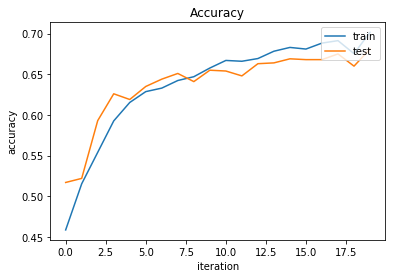

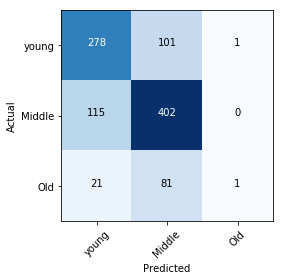

In [30]:
# model 1
hyperparam = {}
hyperparam['H1_filter'] = 8
hyperparam['H2_filter'] = 8
hyperparam['add_layer'] = False
hyperparam['add_dropout'] = False # as ensemble method 
hyperparam['H4_cell'] = 12
m1 = make_model(hyperparam)
# es = EarlyStopping(mode='auto')
m1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_history1 = m1.fit(X_train, Y_train, validation_data=(X_test, Y_test), \
                        epochs=20, batch_size=100, verbose=2, shuffle=True)
# history
plot_history(model_history1)
plot_confusion_matrix(m1, X_test, Y_test, ( 'young', 'Middle', 'Old' ) )

In [14]:
##

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 8)         520       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 12)                24588     
__________

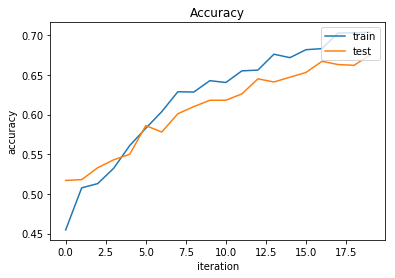

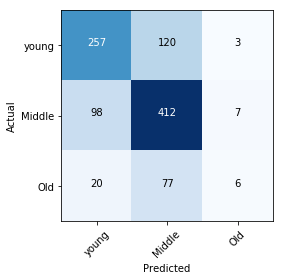

In [31]:
# model2
hyperparam = {}
hyperparam['H1_filter'] = 16
hyperparam['H2_filter'] = 8
hyperparam['add_layer'] = False
hyperparam['add_dropout'] = False # as ensemble method 
hyperparam['H4_cell'] = 12
m2 = make_model(hyperparam)
m2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model_history2 = m2.fit(X_train, Y_train, validation_data=(X_test, Y_test), \
                        epochs=20, batch_size=100, verbose=2, shuffle=True)
plot_history(model_history2)
plot_confusion_matrix(m2, X_test, Y_test, ( 'young', 'Middle', 'Old' ) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 6)         78        
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 6)         150       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 6)         150       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 8, 8, 6)           0         
__________

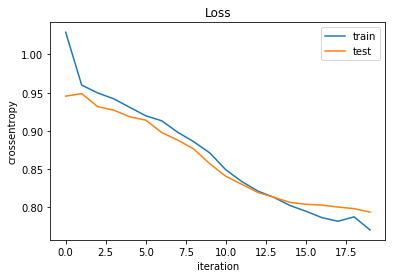

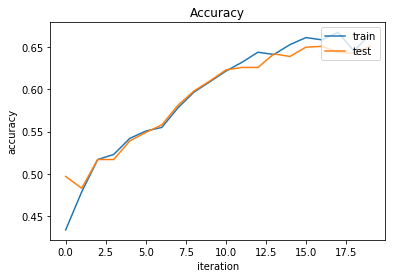

In [32]:
# model3
hyperparam = {}
hyperparam['H1_filter'] = 6
hyperparam['H2_filter'] = 6
hyperparam['add_layer'] = True
hyperparam['add_dropout'] = False # as ensemble method 
hyperparam['H4_cell'] = 12
m3 = make_model(hyperparam)
m3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model_history3 = m3.fit(X_train, Y_train, validation_data=(X_test, Y_test), \
                        epochs=20, batch_size=100, verbose=2, shuffle=True)
plot_history(model_history3)
plot_confusion_matrix(m3, X_test, Y_test, ( 'young', 'Middle', 'Old' ) )

## model4
hyperparam = {}
hyperparam['H1_filter'] = 16
hyperparam['H2_filter'] = 8
hyperparam['add_layer'] = True
hyperparam['add_dropout'] = False # as ensemble method 
hyperparam['H4_cell'] = 24
m4 = make_model(hyperparam)
m4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model_history4 = m4.fit(X_train, Y_train, validation_data=(X_test, Y_test), \
                        epochs=0, batch_size=100, verbose=2, shuffle=True)
plot_history(model_history4)
plot_confusion_matrix(m4, X_test, Y_test, ( 'young', 'Middle', 'Old' ) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 16)        0         
__________

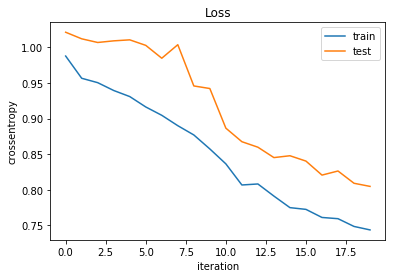

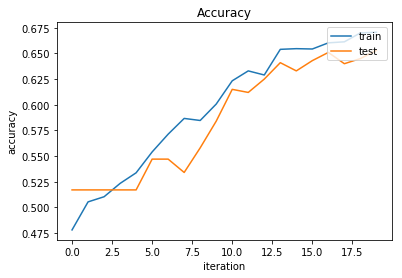

In [34]:
# model5
hyperparam = {}
hyperparam['H1_filter'] = 16
hyperparam['H2_filter'] = 16
hyperparam['add_layer'] = True
hyperparam['add_dropout'] = True # as ensemble method 
hyperparam['H4_cell'] = 24
m4 = make_model(hyperparam)
m4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model_history4 = m4.fit(X_train, Y_train, validation_data=(X_test, Y_test), \
                        epochs=20, batch_size=100, verbose=2, shuffle=True)
plot_history(model_history4)
plot_confusion_matrix(m4, X_test, Y_test, ( 'young', 'Middle', 'Old' ) )